[Jump to where I left off](#contd)

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pymc3 as pm

import arviz as ar
import matplotlib.pyplot as pl
from matplotlib import rcParams
import seaborn as sb
%matplotlib inline

In [4]:
ar.style.use('arviz-darkgrid')

In [3]:
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

In this notebook, I implement the chlorophyll algorithms discussed earlier using a Bayesian framework, which will allow inter-model predictive skill comparison using Information Theory. For each model, implementation follows the sequence below:

* The model is cast in a Bayesian framework using a probabilistic programming language (PPL);
* A set of prior predictive simulations is conducted to ascertain that model priors are reasonable;
* The model is fit using the No U-Turn Sampler (NUTS) variant of Hamiltonian Monte Carlo, and the data subset from NOMAD 2008;
* Model predictive skill and  uncertainty are quantified via posterior distribution evaluation and posterior predictive simulation;
* Inter-model comparisons of model skill are conducted using Information Criteria (IC) including Watanabe Akaike Information Criterion (WAIC) and/or Pareto Smoothed Importance Sampling Leave One Out Cross Validation (LOO). This step 

### 1-A. Implementation of $OC_4$ as pooled model

In [5]:
df_log = pd.read_pickle('./pickleJar/df_log_nopurple_nored_with_MBR.pkl')

In [6]:
df_log.head()

,id,log_rrs443,log_rrs489,log_rrs510,log_rrs555,MaxBlueBand,MaxBlueBandIdx,log_mxBlue2Gr,log_chlor_a,is_hplc
0,1565,-2.773122,-2.482397,-2.394012,-2.126145,Rrs510,2,-0.267867,1.581950,False
1,1566,-2.858857,-2.662956,-2.602191,-2.381734,Rrs510,2,-0.220457,1.544192,False
2,1567,-2.926105,-2.734427,-2.640597,-2.372060,Rrs510,2,-0.268537,1.429914,False
3,1568,-2.759143,-2.541014,-2.436014,-2.156039,Rrs510,2,-0.279976,1.680879,False
4,1559,-2.990409,-2.822196,-2.720468,-2.552735,Rrs510,2,-0.167733,1.371991,False


In [7]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 10 columns):
id                4459 non-null int64
log_rrs443        4456 non-null float64
log_rrs489        4422 non-null float64
log_rrs510        3435 non-null float64
log_rrs555        3255 non-null float64
MaxBlueBand       4459 non-null object
MaxBlueBandIdx    4459 non-null int8
log_mxBlue2Gr     3255 non-null float64
log_chlor_a       4127 non-null float64
is_hplc           4459 non-null bool
dtypes: bool(1), float64(6), int64(1), int8(1), object(1)
memory usage: 287.5+ KB


In [8]:
df_log_small = df_log[['log_mxBlue2Gr', 'MaxBlueBandIdx', 'log_chlor_a']].dropna()
X_ = df_log_small.log_mxBlue2Gr.values
y = df_log_small.log_chlor_a.values
X_poly = np.c_[X_, np.power(X_, 2), np.power(X_, 3), np.power(X_, 4)]
X_poly_s = (X_poly - X_poly.mean(axis=0)) / X_poly.std(axis=0)

Writing $OC_4$ as a Bayesian regression model takes the following form

In [9]:
with pm.Model() as m_oc4:
    α = pm.Normal('α', 0, 1)
    β = pm.Normal('β', 0, 1, shape=X_poly.shape[1])
    σ = pm.Exponential('σ', 1)
    μ =  α + pm.math.dot(X_poly_s, β)
    log_chl = pm.Normal('log_chl', mu=μ, sd=σ, observed=y)

In [10]:
render = pm.model_to_graphviz(m_oc4)

render.format='png'
render.render('m_oc4_pooled', directory='./figJar');

<center><h3>Pooled Bayesian $OC_4$ polynomial regression model</h3></center>
<img src='./figJar/m_oc4_pooled.png?:0' />
<br><br>
<h3>Prior predictive sampling for sanity checks on priors</h3>

In [11]:
m_oc4_priors = pm.sample_prior_predictive(model=m_oc4,)

In [12]:
log_chl_prior = m_oc4_priors['log_chl']

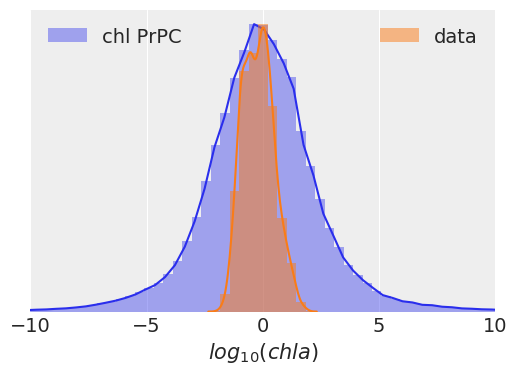

In [13]:
f, ax = pl.subplots(figsize=(6, 4))
sb.distplot(log_chl_prior.flatten(), bins=np.linspace(-10, 10),
            label='chl PrPC', ax=ax)
ax.set_xlim(-10, 10)
ax2 = ax.twinx()
##sb.distplot(log_chl_prior.flatten(), label=)
sb.distplot(y, bins=np.linspace(-10 ,10,), hist_kws={'alpha': 0.5, 'color': 'C1'},
            kde_kws={'color': 'C1',}, ax=ax2, label='data')
ax.legend(loc='upper left')
ax2.legend();
ax.set_yticks([])
ax2.set_yticks([])
ax.set_xlabel('$log_{10}(chl a)$')
f.savefig('./figJar/m_oc4_pooled_prior_predictive_check.png', dpi=300)

The above shows that the model priors are constrained so as to give very little credibility to unrealistic values of chlorophyll.
<h3>Model fit and analysis of results</h3>

In [14]:
with m_oc4:
    trace_oc4 = pm.sample(2000, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 7000/7000 [01:00<00:00, 116.66draws/s]


In [15]:
#m_oc4_posteriors = {k: trace_oc4.get_values(k) for k in ['α', 'β', 'σ']}
posterior_predictive_oc4 = pm.sample_posterior_predictive(trace_oc4, 500, m_oc4)

100%|██████████| 500/500 [00:00<00:00, 766.06it/s]


In [16]:
inference_data_oc4 = ar.from_pymc3(trace=trace_oc4,
                                   #prior=m_oc4_priors,
                                   posterior_predictive=posterior_predictive_oc4)

In [17]:
inference_data_oc4.to_netcdf('./ModelResults/oc4_pooled.nc')

'./ModelResults/oc4_pooled.nc'

In [74]:
df_log_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2972 entries, 0 to 4458
Data columns (total 3 columns):
log_mxBlue2Gr     2972 non-null float64
MaxBlueBandIdx    2972 non-null int8
log_chlor_a       2972 non-null float64
dtypes: float64(2), int8(1)
memory usage: 72.6 KB


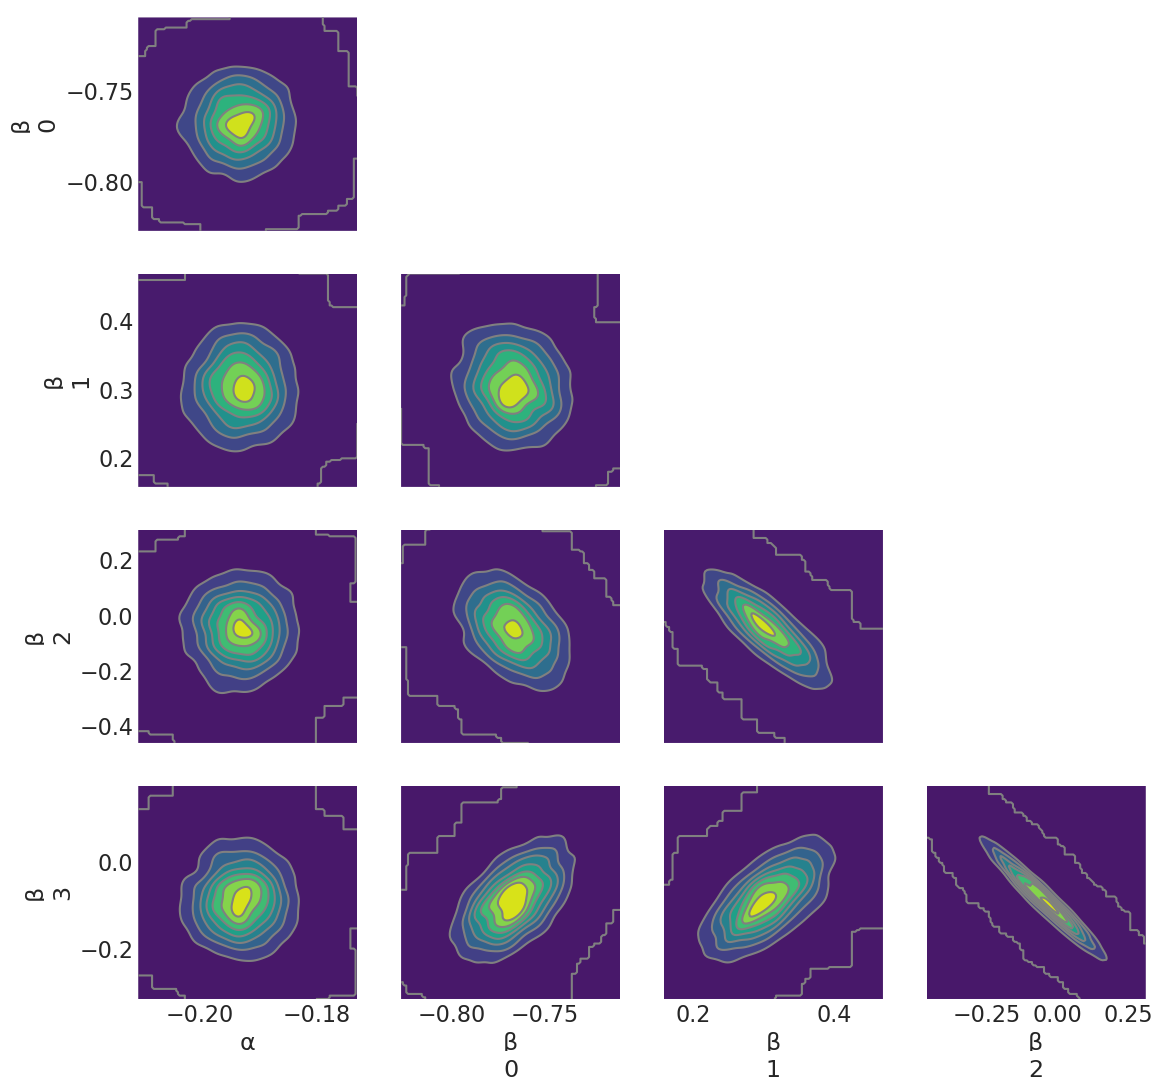

In [18]:
f, axs = pl.subplots(ncols=4, nrows=4, figsize=(13, 13))
ar.plot_pair(inference_data_oc4, var_names=['α', 'β'], kind='kde', divergences=True,
            textsize=16, ax=axs);
f = pl.gcf()
f.savefig('./figJar/m_oc4_pooled_pairwise_param.png', dpi=300)

The above shows high correlation between parameters of the higher power output, suggesting little addition information is gained from these terms.

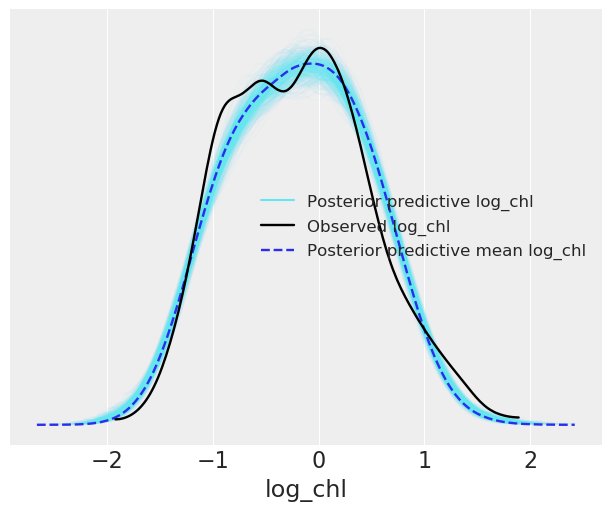

In [19]:
ax = ar.plot_ppc(inference_data_oc4, alpha=0.05, textsize=16, figsize=(6, 5));
f = pl.gcf()
f.savefig('./figJar/m_oc4_pooled_posterior_predictive_check_kde.png')

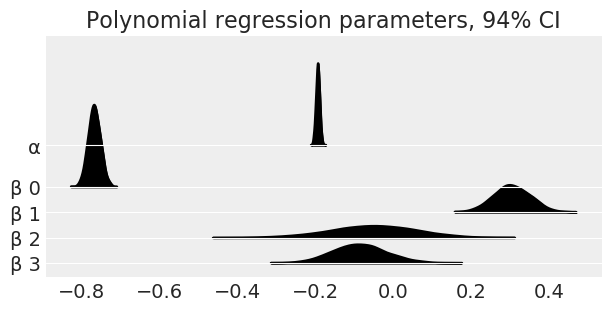

In [20]:
f, axs = ar.plot_forest(inference_data_oc4, kind='ridgeplot', var_names=['α', 'β'],
                         combined=True, ridgeplot_overlap=8, colors='k', figsize=(6, 3),
                       textsize=16)
axs[0].set_title('Polynomial regression parameters, 94% CI', fontsize=16)
axs[0].grid(axis='y')

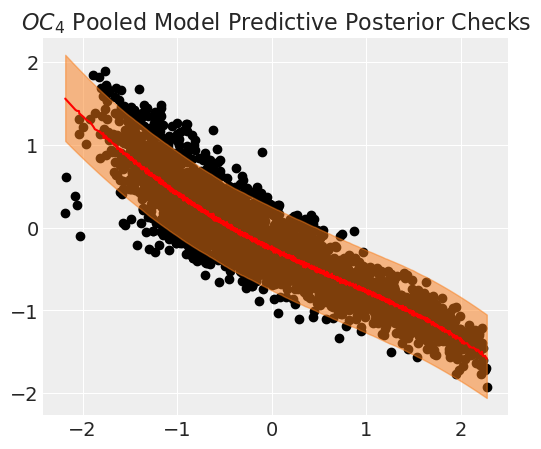

In [21]:
f, ax = pl.subplots(figsize=(6, 5))
idx = X_poly_s[:,0].argsort()
ax.scatter(X_poly_s[:,0], y, color='k',)
ar.plot_hpd(X_poly_s[:,0], posterior_predictive_oc4['log_chl'], ax=ax)
ax.plot(X_poly_s[idx, 0], posterior_predictive_oc4['log_chl'].mean(axis=0)[idx], color='r');
ax.set_title('$OC_4$ Pooled Model Predictive Posterior Checks', fontsize=16);
f.savefig('./figJar/m_oc4_pooled_posterior_predictive_check.png', dpi=300)

<a id='contd'></a>
### 1 - B Implementation of $OC_4$ as partially pooled model with max blue grouping
For this model, I use the blue band used in the MBR to group the data,  enabling specific slopes and intercept for each group

In [22]:
# Get grouping index
mbr_group_idx = df_log_small.MaxBlueBandIdx.values
n_groups = np.unique(mbr_group_idx).size
X_polyT = X_poly.T
X_poly_s_T = X_poly_s.T

In [62]:
with pm.Model() as m_oc4_pp:
    hyp_α_μ = pm.Normal('hyp_α_μ', mu=0, sd=.1)
    hyp_α_σ = pm.HalfCauchy('hyp_α_σ', 0.5)
    hyp_β_μ = pm.Normal('hyp_β_μ', mu=0, sd=.01)
    hyp_β_σ = pm.HalfCauchy('hyp_β_σ', 0.5)
    α = pm.Normal('α', mu=hyp_α_μ, sd=hyp_α_σ, shape=n_groups)
    β0 = pm.Normal('β0', mu=hyp_β_μ, sd=hyp_β_σ, shape=n_groups)
    β1 = pm.Normal('β1', mu=hyp_β_μ, sd=hyp_β_σ, shape=n_groups)
    β2 = pm.Normal('β2', mu=hyp_β_μ, sd=hyp_β_σ, shape=n_groups)
    β3 = pm.Normal('β3', mu=hyp_β_μ, sd=hyp_β_σ, shape=n_groups)
    σ = pm.Exponential('σ', 1)
    μ = α[mbr_group_idx] + β0[mbr_group_idx] * X_poly_s_T[0] \
            + β1[mbr_group_idx] * X_poly_s_T[1] \
            + β2[mbr_group_idx] * X_poly_s_T[2] \
            + β3[mbr_group_idx] * X_poly_s_T[3]
    log_chl = pm.Normal('log_chl', mu=μ, sd=σ, observed=y)

In [63]:
render = pm.model_to_graphviz(m_oc4_pp)

render.format='png'
render.render('m_oc4_partially_pooled_graph', directory='./figJar');

<img src='./figJar/m_oc4_partially_pooled_graph.png?:3'/>

In [64]:
m_oc4_pp_priors = pm.sample_prior_predictive(model=m_oc4_pp)

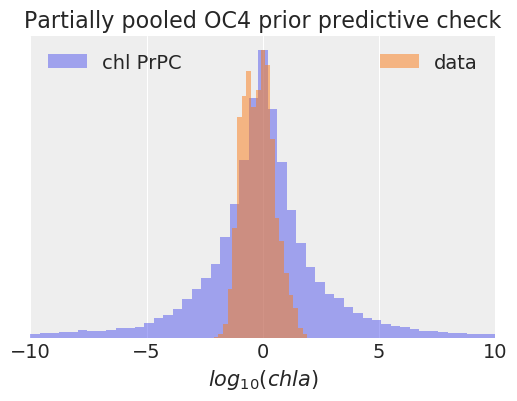

In [65]:
log_chl_oc4_pp_prior = m_oc4_pp_priors['log_chl']
f, ax = pl.subplots(figsize=(6, 4))
sb.distplot(log_chl_oc4_pp_prior.flatten(), kde=False,
            bins=np.linspace(-10, 10,),
            label='chl PrPC', ax=ax, norm_hist=True)
ax.set_xlim(-10, 10)
ax2 = ax.twinx()
sb.distplot(y, bins=np.linspace(-10 ,10, num=100), kde=False,
            hist_kws={'alpha': 0.5, 'color': 'C1'},
            kde_kws={'color': 'C1',}, ax=ax2, label='data',
            norm_hist=True)
ax.legend(loc='upper left')
ax2.legend();
ax.set_yticks([])
ax2.set_yticks([])
ax.set_xlabel('$log_{10}(chl a)$')
ax.set_title('Partially pooled OC4 prior predictive check')
f.savefig('./figJar/m_oc4_partially_pooled_prior_predictive_check.png', dpi=300);

In [66]:
with m_oc4_pp:
    trace_oc4_pp = pm.sample(2000, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β3, β2, β1, β0, α, hyp_β_σ, hyp_β_μ, hyp_α_σ, hyp_α_μ]
Sampling 2 chains: 100%|██████████| 7000/7000 [21:10<00:00,  4.84draws/s]  
The number of effective samples is smaller than 25% for some parameters.


In [67]:
posterior_predictive_oc4_pp = pm.sample_posterior_predictive(trace_oc4_pp, 500, m_oc4_pp)

100%|██████████| 500/500 [00:00<00:00, 754.82it/s]


In [68]:
inference_data_oc4_pp = ar.from_pymc3(trace=trace_oc4_pp,
                                   prior=m_oc4_pp_priors,
                                   posterior_predictive=posterior_predictive_oc4_pp,
                                    coords={'MaxBlue': ['Rrs443', 'Rrs490', 'Rrs510']},
                                      dims={'α': ['MaxBlue'],'β0':['MaxBlue'], 'β1':['MaxBlue'],
                                            'β2':['MaxBlue'], 'β3':['MaxBlue']})

In [69]:
inference_data_oc4_pp.to_netcdf('./ModelResults/oc4_pp.nc')

'./ModelResults/oc4_pp.nc'

In [70]:
inference_data_oc4_pp = ar.from_netcdf('./ModelResults/oc4_pp.nc')

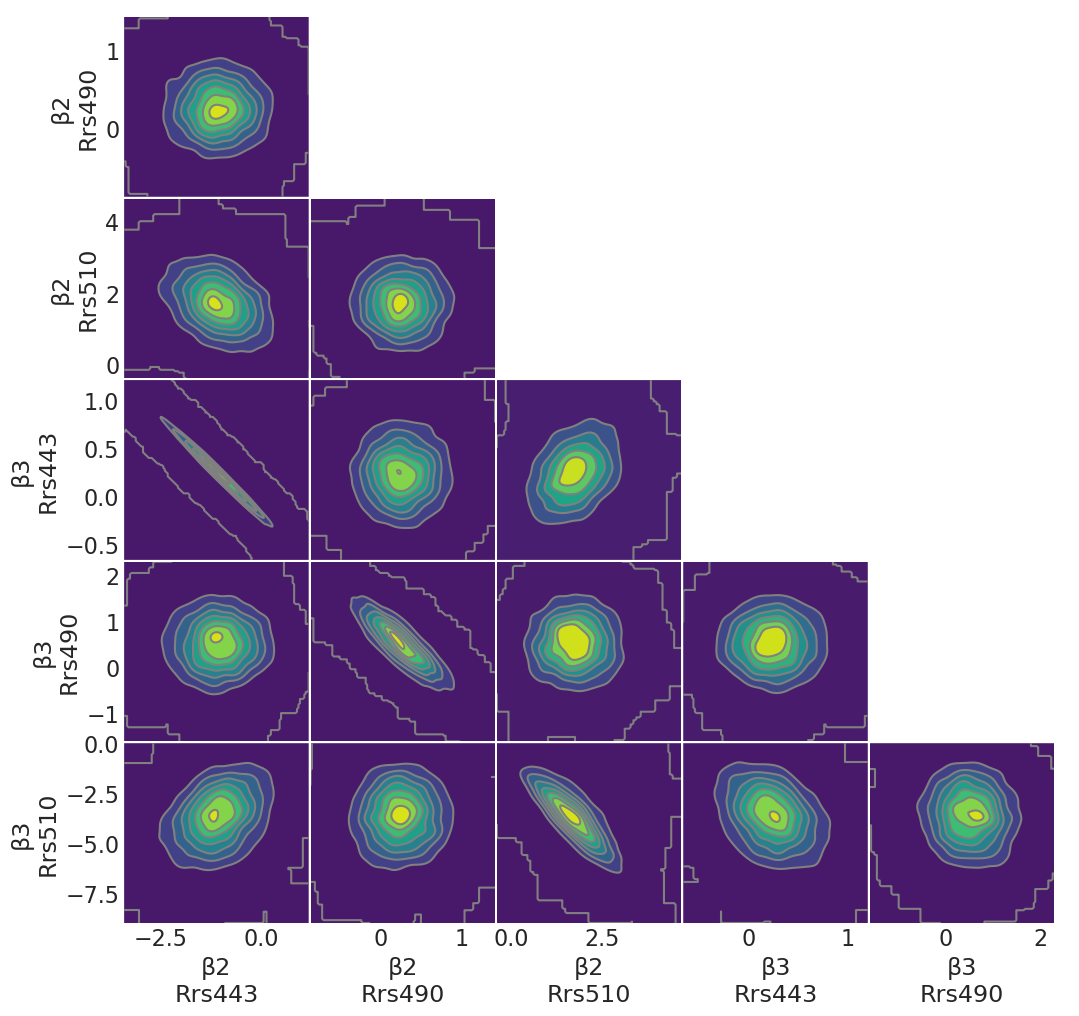

In [71]:
f, axs = pl.subplots(5, 5, figsize=(12, 12),)
ar.plot_pair(inference_data_oc4_pp, var_names=['β2', 'β3'], kind='kde', divergences=True,
             coords={'MaxBlue': ['Rrs443', 'Rrs490', 'Rrs510']},
            textsize=16, ax=axs
            );
f.subplots_adjust(wspace=0.01, hspace=0.01)

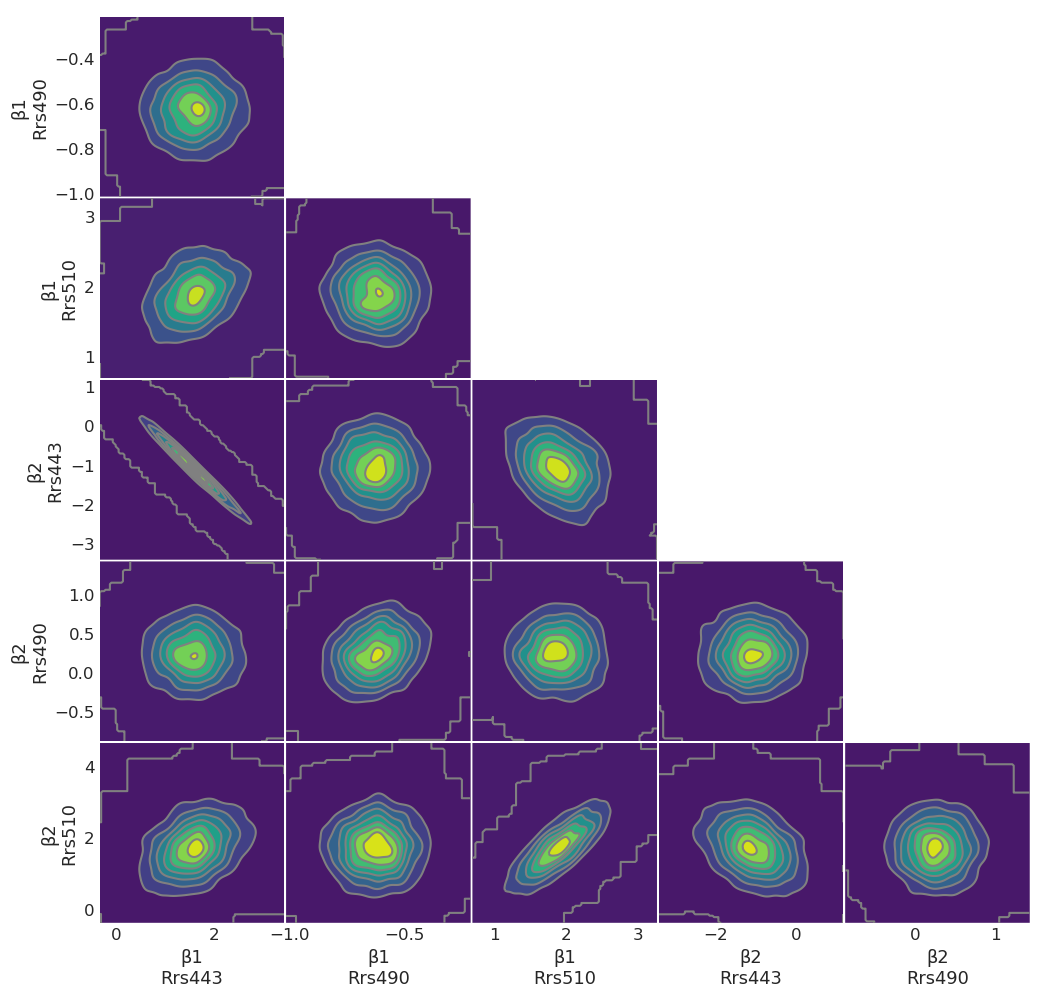

In [72]:
f, axs = pl.subplots(5, 5, figsize=(12, 12),)
ar.plot_pair(inference_data_oc4_pp, var_names=['β1', 'β2'], kind='kde',
             divergences=True,
             coords={'MaxBlue': ['Rrs443', 'Rrs490', 'Rrs510']},
            textsize=12, ax=axs
            );
f.subplots_adjust(wspace=0.01, hspace=0.01)

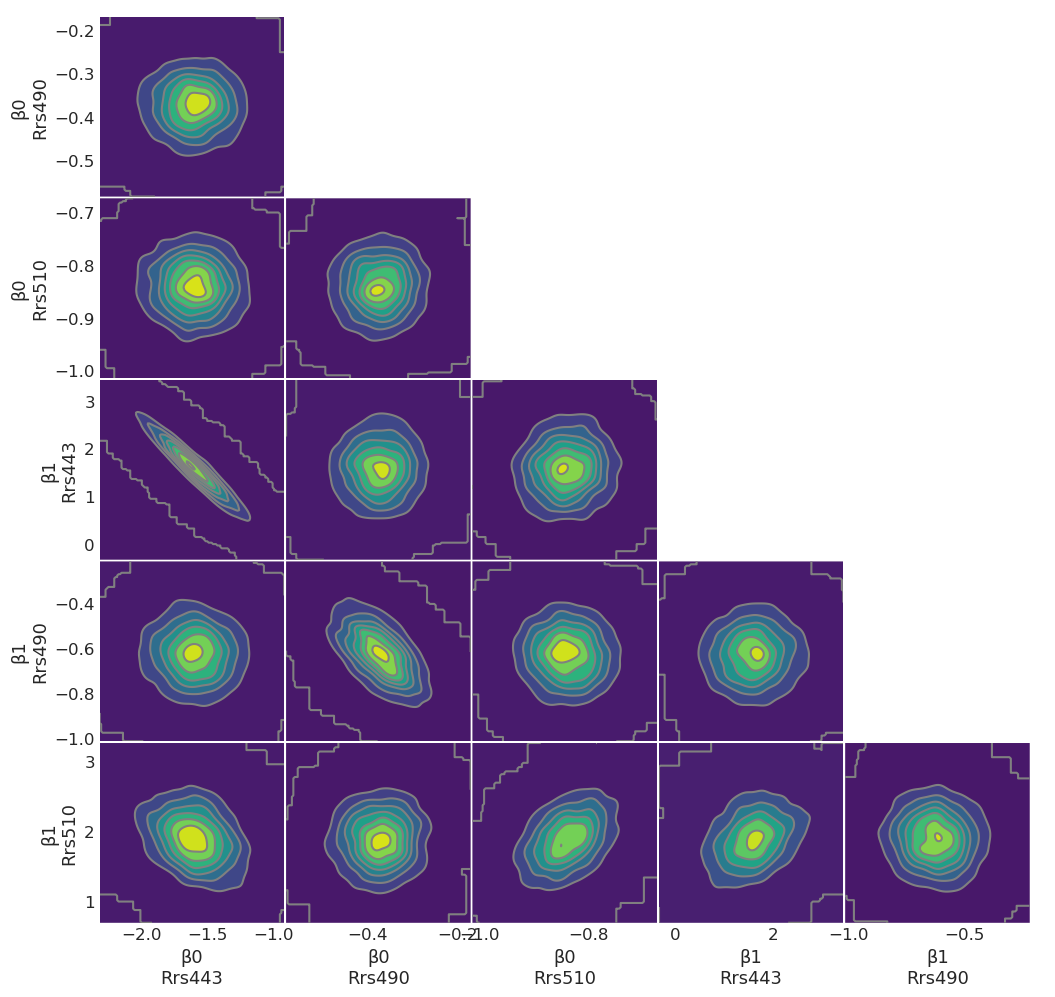

In [73]:
f, axs = pl.subplots(5, 5, figsize=(12, 12),)
ar.plot_pair(inference_data_oc4_pp, var_names=['β0', 'β1'], kind='kde',
             divergences=True,
             coords={'MaxBlue': ['Rrs443', 'Rrs490', 'Rrs510']},
            textsize=12, ax=axs
            );
f.subplots_adjust(wspace=0.01, hspace=0.01)